# Compare the optimized archtitecture to the actual architecture:

Import all necessary packages:

In [49]:
# Jupyter packagesb
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Common packages, you know them from before 
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import math
import copy
from typing import *
import json
import string
import os
import pickle
from pymoo_implementation.problem.problem_mlp_optimization import create_MLP_from_parameter

# Setup jupyter
%matplotlib inline

In [50]:
PATH = (os.getcwd().replace("scripts", ""))


Set constants:

In [51]:
TRAIN_DATA_COUNT = 100000
EVALUTAION_DATA_COUNT = TRAIN_DATA_COUNT

In [52]:
# Data constants
data_path_1 = PATH + "data/random1"
data_path_2 = PATH + "data/random2"
data_path_3 = PATH + "data/random3"
path_list = [data_path_1, data_path_2, data_path_3]

Read the data:

In [53]:
def get_data(data_path : string, data_count: int): 
    original_data = pd.read_csv(data_path, delimiter='\t');
    data = original_data.iloc[:
    data_count
    , 9:]
    input = data.iloc[:, :-9]
    target = data.iloc[:, -9:-7]

    return input, target, len(original_data)
    """
    input = data.iloc[:, :-9]
    target = data.iloc[:, -9:-7]
    old_mlp_target = data.iloc[:, -6:-3]
    old_mlp_target.pop('ScaleTheta')
    """

In [54]:
def data_prep(model, input, target):
    print("Evaluate the model:")
    #results = model.evaluate(input.values, target.values, batch_size=128)
    #print("evaluation loss, evaluation acc:", results, "\n")
    
    print("Predict target and compare with true label:")
    y_pred = model.predict(input)

    z_list = np.array([])
    theta_list = np.array([])

    true_z_list = np.array([])
    true_theta_list = np.array([])

    for element in y_pred:
        z_list = np.append(z_list, element[0]) 
        theta_list = np.append(theta_list, element[1])

    for element in target.values:
        true_z_list = np.append(true_z_list, element[0]) 
        true_theta_list = np.append(true_theta_list, element[1])
    
    return z_list, true_z_list

Load the model:

In [55]:
def load_model(input_data, target_data, parameter):

    # add early stopping callback to save time
    es = EarlyStopping(monitor = f'val_{"accuracy"}', mode ='max', patience = 5)
    # Train the model
    cnn_model = create_MLP_from_parameter(parameter)
    cnn_model.fit(input_data, target_data, epochs=500, validation_split = 0.2, batch_size=2, callbacks = [es], use_multiprocessing=True, verbose=0)

    return cnn_model

train the models with the random1 dataset:

In [56]:
#res = pickle.load(open(f"{PATH}pickled_data/res-ITIV-set1-20pop-10ly-2023-02-09.p", "rb"))
#for history in res:
#        last_best = history[-1].opt.get("X")

#opt_parameter = last_best[0][:-1]
input, target, lenght = get_data(data_path_1, TRAIN_DATA_COUNT)
opt_parameter = np.array([187, 82, 217])

In [ ]:
opt_model = load_model(input, target, np.array([187, 82, 217]))
old_model = load_model(input, target, np.array([81]))
#pickle.dump(opt_model, open(f"{PATH}pickled_data/trained_opt_model_{opt_parameter}", "wb"))

In [ ]:
val_input, val_target, lenght = get_data(data_path_1, EVALUTAION_DATA_COUNT)

print (f"accuracy for old model: {old_model.evaluate(val_input, val_target)[1]:0.03f}")
print (f"accuracy for optimized model: {opt_model.evaluate(val_input, val_target)[1]:0.03f}")

NameError: name 'EVALUTAION_DATA_COUNT' is not defined

Plot performace comparision:

Evaluate the model:
Predict target and compare with true label:
3125/3125 [==============================] - 3s 1ms/step
Evaluate the model:
Predict target and compare with true label:
3125/3125 [==============================] - 3s 1ms/step


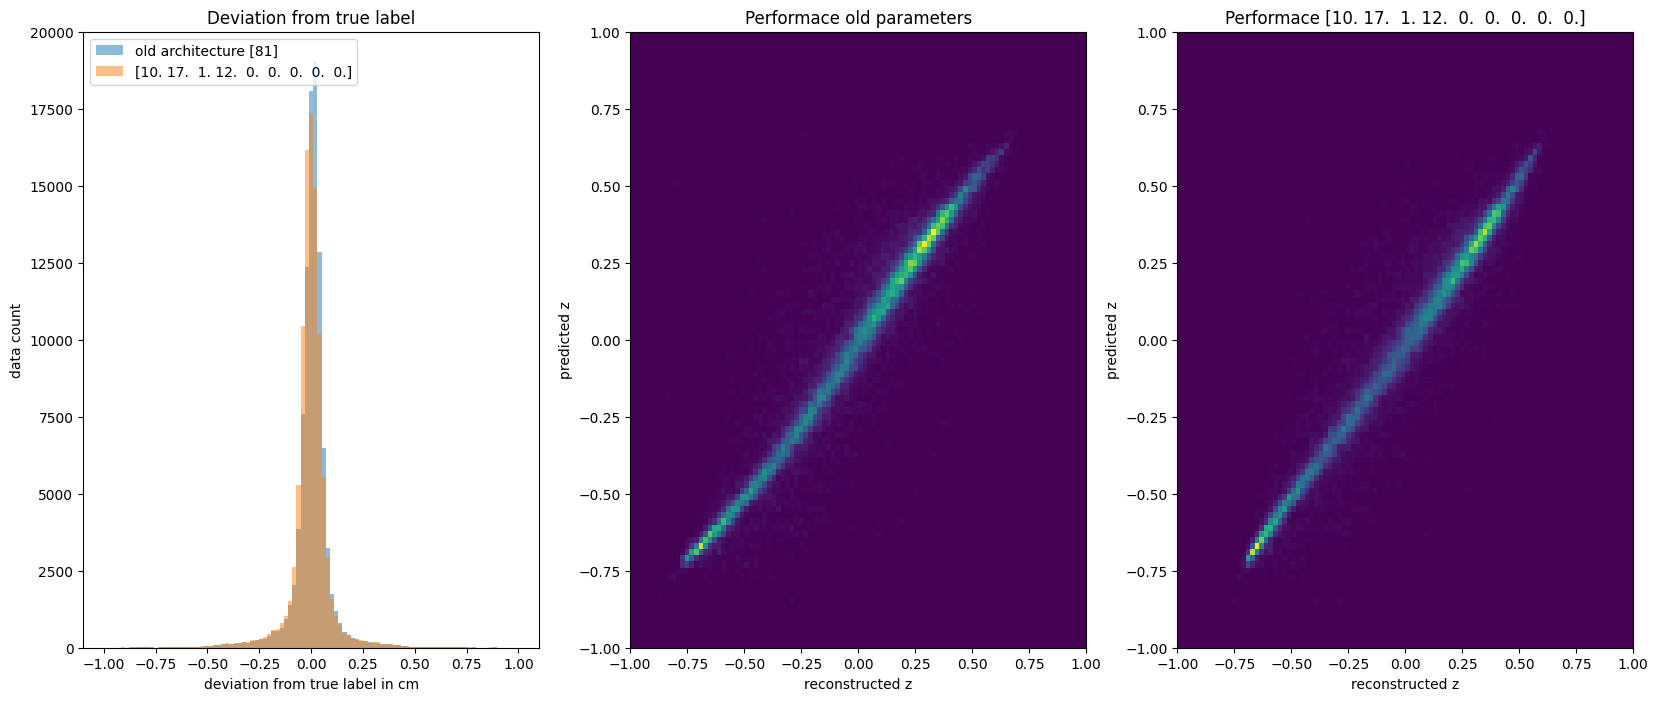

In [ ]:
def plot_z_deviation(opt_model,old_model, title, save_name):
    hist_bins = np.linspace(-1, 1, 100)
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(20, 8)

    z_list_opt, true_z_list = data_prep(opt_model, input, target)
    z_list_old, true_z_list = data_prep(old_model, input, target)

    delta_z_opt = (z_list_opt).astype(float) - (true_z_list).astype(float)
    delta_z_old = (z_list_old).astype(float) - (true_z_list).astype(float)
    

    ax[0].set_title(f'Deviation from true label (for {EVALUTAION_DATA_COUNT} tracks)')
    ax[0].set_xlabel("deviation from true label in cm")
    ax[0].set_ylabel("data count")

    ax[0].hist(delta_z_opt, hist_bins, density=False,  alpha=0.5, label='old architecture [81]')
    ax[0].hist(delta_z_old, hist_bins, density=False,  alpha=0.5, label=f'{opt_parameter}')
    ax[0].legend(loc = 'upper left')

    ax[1].set_title(f'Performace old parameters (for {EVALUTAION_DATA_COUNT} tracks)')
    ax[1].set_xlabel("reconstructed z")
    ax[1].set_ylabel("predicted z")
    
    hist2d = ax[1].hist2d(z_list_old, true_z_list, [100, 100], density = False, range=[[-1, 1], [-1, 1]])
    fig[1].colorbar(hist2d[3], ax=ax)

    ax[2].set_title(f'Performace {opt_parameter}')
    ax[2].set_xlabel("reconstructed z")
    ax[2].set_ylabel("predicted z")
    
    hist2d = ax[2].hist2d(z_list_opt, true_z_list, [100, 100], density = False, range=[[-1, 1], [-1, 1]])
    fig[2].colorbar(hist2d[3], ax=ax)

    plt.show()

plot_z_deviation(opt_model, old_model, 'Evaluation for Expert 0 (all 9 TS are present)',  "new_model1_z_diff" )

In [ ]:
def get_hist(model, title, save_name):

    hist_bins = np.linspace(-3, 3, 100)
    fig, ax = plt.subplots(3, 2)
    fig.set_size_inches(20, 15)
    i = 0
    for data_path in path_list:
        input, target, lenght = get_data(data_path, EVALUTAION_DATA_COUNT)
        z_list, real_z_list, old_z_list = data_prep(model, input, target)
        opt_list, real_z_list, old_z_list = data_prep(opt_model, input, target)

        ax[i, 0].set_title(f'target data distribution for dataset {i + 1}')
        ax[i, 0].set_xlabel("z")
        ax[i, 0].set_ylabel("data count")

        ax[i, 1].set_title(f'predicted data distribution for dataset {i + 1}')
        ax[i, 1].set_xlabel("z")
        ax[i, 1].set_ylabel("data count")
        
        n1, bins1, patches1 = ax[i, 0].hist(real_z_list, hist_bins, density=False, alpha = 1, label = 'target data')
        n2, bins2, patches2 = ax[i, 0].hist(z_list, hist_bins, density=False, range=(-10, 10), alpha=0.5, label='predicted data \n(from given mlp weights)')
        
        n1, bins1, patches1 = ax[i, 1].hist(real_z_list, hist_bins, density=False, alpha = 1, label = 'target data')
        n3, bins3, patches3 = ax[i, 1].hist(opt_list, hist_bins, density=False, range=(-10, 10), alpha=0.5, label='data included in dataset')
        ax[i, 1].legend(loc = 'upper left')
        ax[i, 0].legend(loc = 'upper left')
        i = i + 1
    
    fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(f"{PATH}/plots/{save_name}.png")
    plt.show()


get_hist(model_1, 'Evaluation for Expert 0 (all 9 TS are present)',  "new_model1_z_hist" )
get_hist(model_2, 'Evaluation for Expert 1 (outer Most SLL TS from SSL 4 missing)',  "new_model2_z_hist" )
get_hist(model_3, 'Evaluation for Expert 2 (TS from SSL 3 missing)',  "new_model3_z_hist" )
get_hist(model_4, 'Evaluation for Expert 3 (TS form SLL2 missing)',  "new_model4_z_hist" )
get_hist(model_5, 'Evaluation for Expert 4 (inner Most SSL RS from SSL 1 missing)',  "new_model5_z_hist" )

NameError: name 'model_1' is not defined